In [1]:
%matplotlib inline

import os

import matplotlib
import matplotlib.pyplot as pyplot
import geopandas as gpd
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.affinity import scale

from tile_units import TileUnit
from tile_units import TileShape
from tile_map import Tiling

pyplot.rcParams['pdf.fonttype'] = 42
pyplot.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
def get_filename_label(path):
    fname = os.path.basename(path)
    return fname.partition("-")[0]

## Get the data

In [3]:
path1 = "../data/002448-results-GWR_fixbw-COVID_cases_per_1000persons__over_both_periods-regen-BlackAsianHispanic-life_expect-econ_sect_shares.gpkg"

path2 = "../data/006092-results-GWR_fixbw-COVID_cases_per_1000persons__over_period_1-BlackAsianHispanic.gpkg"

gwr1 = gpd.read_file(path1)
gwr1["ID"] = list(range(gwr1.shape[0]))

gwr2 = gpd.read_file(path2)
gwr2["ID"] = list(range(gwr2.shape[0]))

In [4]:
d = 50000
inset_sf = 0.95

## A H3 (or 7-colouring) tile unit
This is a 7 colouring of the tiling by regular hexagons.

<AxesSubplot:>

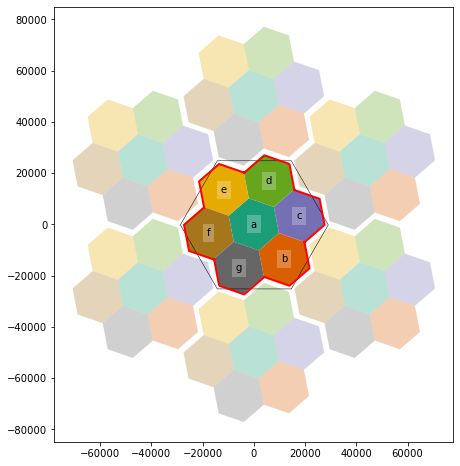

In [5]:
# make a base tile to start
hex_7_tile = TileUnit(spacing = d, crs = gwr1.crs, 
                      tile_shape = TileShape.HEXAGON)

# the basic H3 level to level scale factor and rotation
sf = 1 / np.sqrt(7)  
rotation = np.degrees(np.arctan(1 / 3 / np.sqrt(3)))

hex = scale(hex_7_tile.tile.geometry[0], sf, sf)
corners = [p for p in hex.exterior.coords]
hex = rotate(hex, 30)
hexes = [hex] + [translate(
    hex, x * np.sqrt(3), y * np.sqrt(3)) for x, y in corners[:-1]]
hexes = gpd.GeoSeries(hexes, crs = gwr2.crs).rotate(
    rotation, origin = (0, 0)).scale(inset_sf, inset_sf, origin = (0, 0))

hex_7_tile.elements = gpd.GeoDataFrame(
    data = {"element_id": list("abcdefg")}, crs = gwr1.crs,
    geometry = hexes)

reg_tile = hex_7_tile.elements.geometry.buffer(
        1e-3, join_style = 2).unary_union.buffer(-1e-3)
hex_7_tile.regularised_tile = gpd.GeoDataFrame(
    geometry = gpd.GeoSeries([reg_tile]), crs = gwr1.crs)

hex_7_tile.plot(r = 1)

## Hex 3-colouring tile unit
A 3-colourable tiling of regular hexagons. Not yet implemented, so make it by hand here.

<AxesSubplot:>

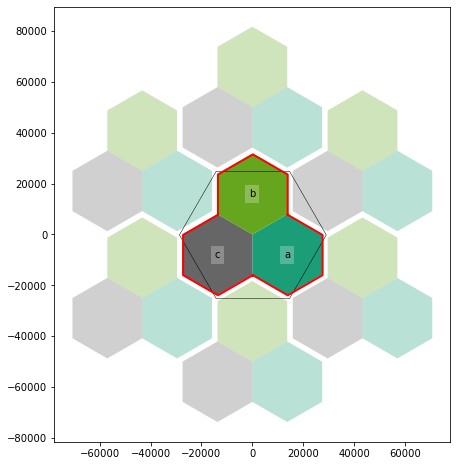

In [6]:
hex_3_tile = TileUnit(spacing = d, crs = gwr2.crs, 
                      tile_shape = TileShape.HEXAGON)

# Rotate and scale
hex = rotate(hex_3_tile.tile.geometry[0], 30, origin = (0, 0))
hex = scale(hex, 1 / np.sqrt(3), 1 / np.sqrt(3), origin = (0, 0))
# Copy and translate to alternate corners
corners = [p for i, p in enumerate(hex.exterior.coords) if i in (0, 2, 4)]
hexes = [translate(hex, p[0], p[1]) for p in corners]

hexes = gpd.GeoSeries(hexes).scale(inset_sf, inset_sf, origin = (0, 0))

hex_3_tile.elements = \
    gpd.GeoDataFrame(data = {"element_id": list("abc")}, 
                     crs = gwr2.crs, geometry = hexes)

reg_tile = hex_3_tile.elements.geometry.buffer(
        1e-3, join_style = 2).unary_union.buffer(-1e-3)
hex_3_tile.regularised_tile = gpd.GeoDataFrame(
    geometry = gpd.GeoSeries([reg_tile]), crs = gwr2.crs)

hex_3_tile.plot(r = 1)

## Tile maps

In [11]:
hex7_tiling = Tiling(hex_7_tile, gwr1, id_var = "ID")
hex7_map = hex7_tiling.get_tiled_map(prioritise_tiles = True)

hex3_tiling = Tiling(hex_3_tile, gwr2, id_var = "ID")
hex3_map = hex3_tiling.get_tiled_map(
    rotation = 0, prioritise_tiles = True)

## And make maps
First we have to make variables and colourmaps dictionaries.

In [12]:
betas7 = [n for n in gwr1.columns if "_beta_classified" in n]
hex7_map.variables = dict(zip(list("abcdefg"), betas7))
hex7_map.colourmaps =  dict(zip(
    betas7, 7 * [{'associated with LESS covid': "#69A7CF",
                  'not significant': "#C7C7C7",
                  'associated with MORE covid': "#EF8A62"}]))
hex7_map.dpi = 150
hex7_map.figsize = (24, 18)

betas3 = [n for n in gwr2.columns if "_beta_classified" in n]
hex3_map.variables = dict(zip(list("abc"), betas3))
hex3_map.colourmaps =  dict(zip(
    betas3, 3 * [{'associated with LESS covid': "#69A7CF",
                  'not significant': "#C7C7C7",
                  'associated with MORE covid': "#EF8A62"}]))
hex3_map.dpi = 150
hex3_map.figsize = (24, 18)

fig=<Figure size 1728x1296 with 2 Axes>


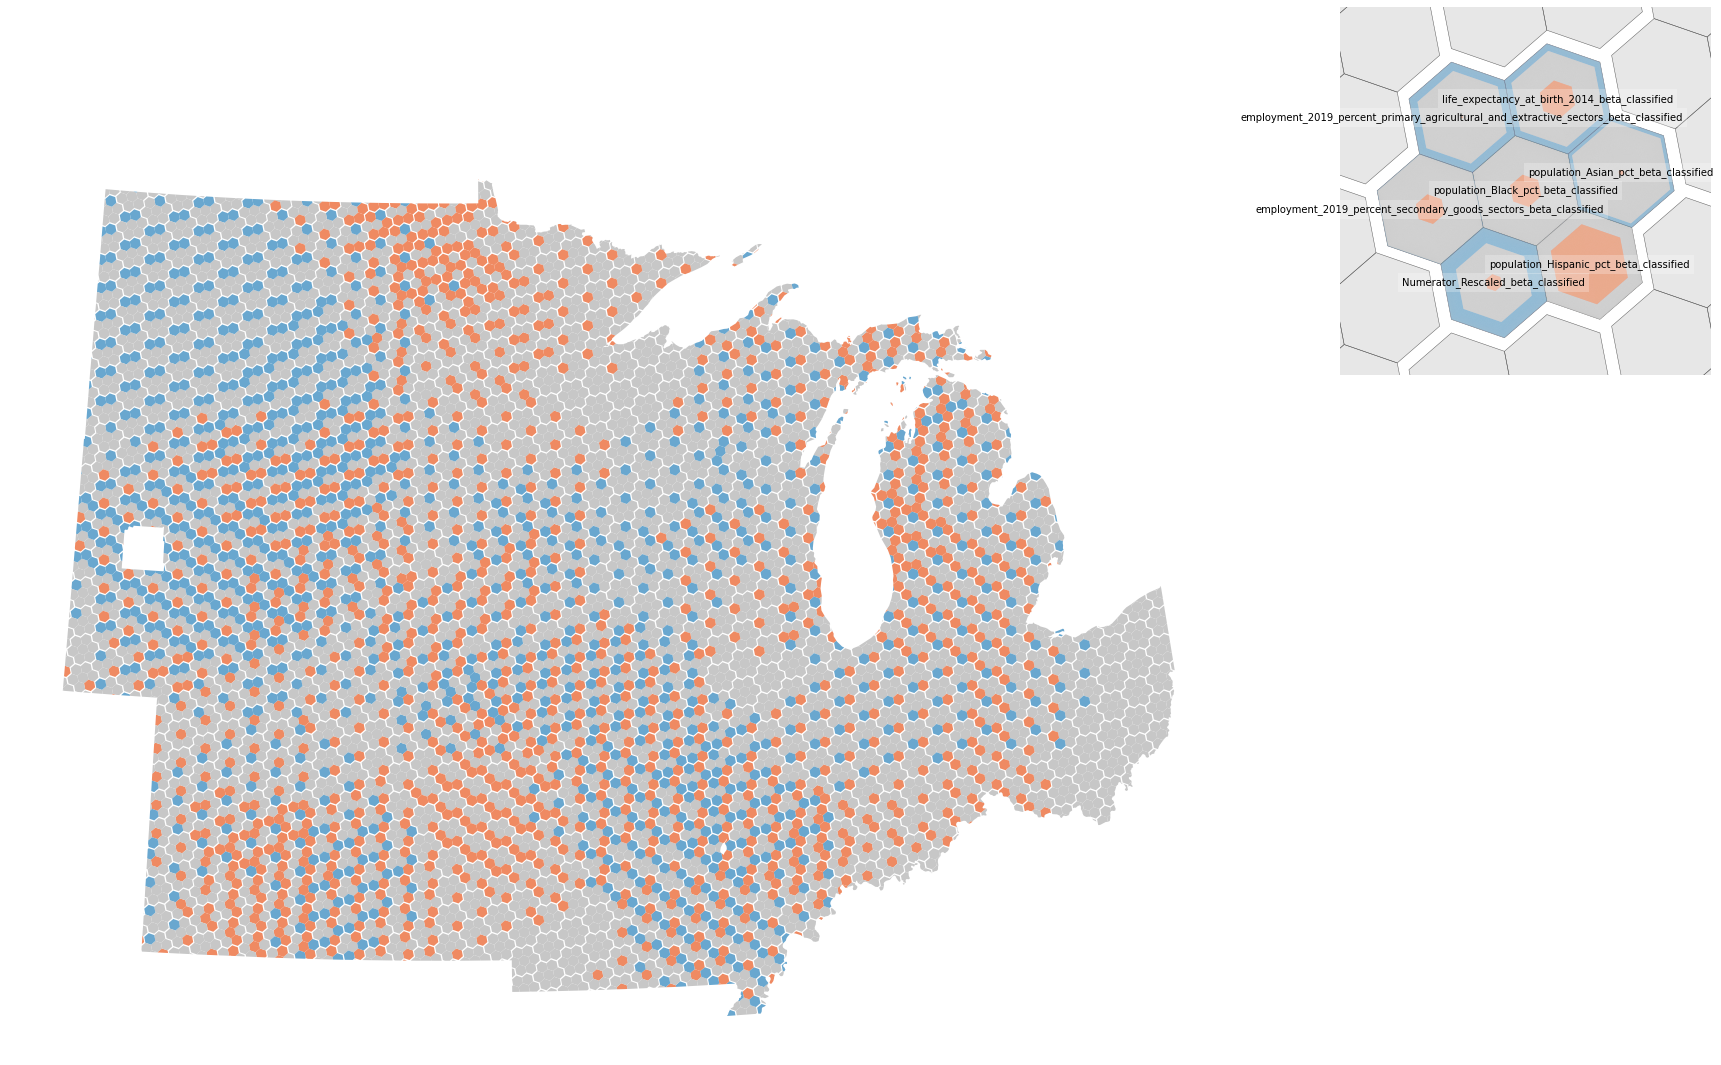

In [13]:
fig = hex7_map.render(legend_zoom = 0.8)
fig.savefig(f"hex_{get_filename_label(path1)}.pdf")

fig=<Figure size 1728x1296 with 2 Axes>


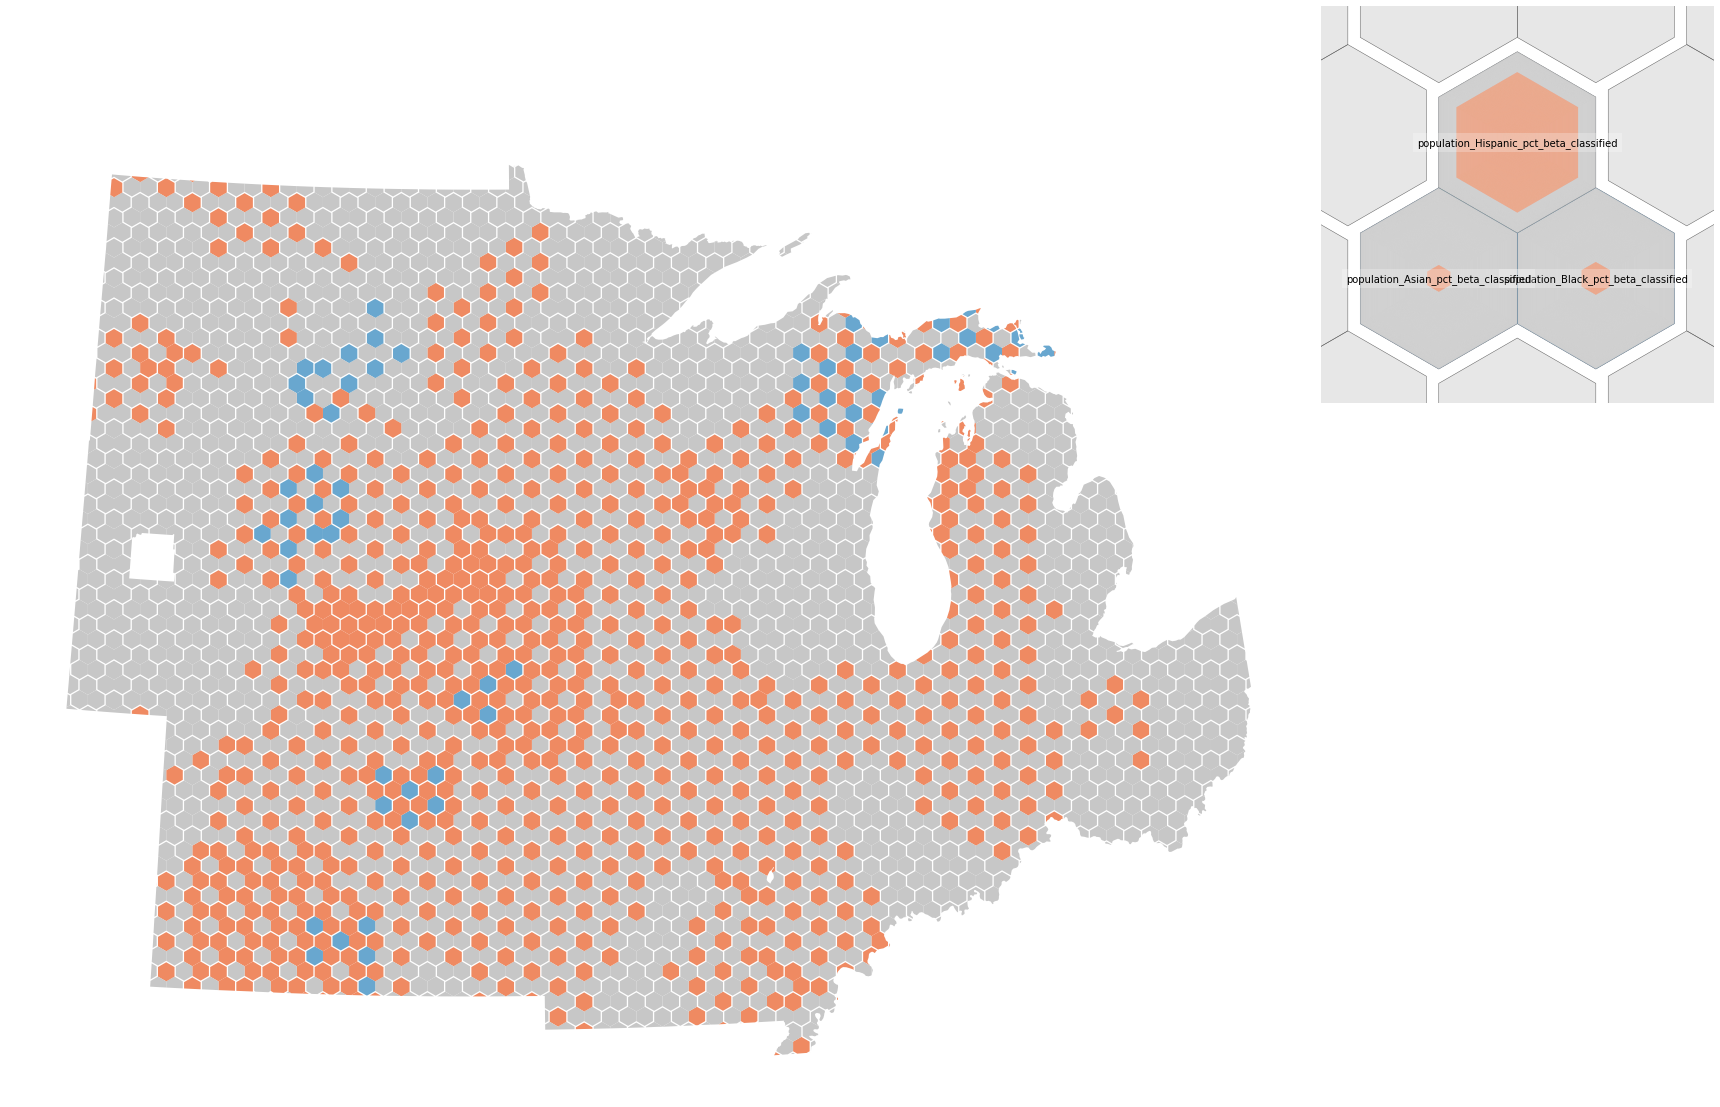

In [14]:
fig = hex3_map.render(legend_zoom = 0.8)
fig.savefig(f"hex_{get_filename_label(path2)}.pdf")